# **Homework 2 Problem 1**

In this problem, you'll be exploring decision trees more deeply: specifically, on managing overfitting using decision tree pruning.

## 1.0) Loading Data and Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# we're using the Wine dataset from sklearn.datasets 
from sklearn import datasets
# Remember you have to run this cell block before continuing!

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


# We need to ignore FutureWarnings due to a bug in our version of sklearn
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Important Note about Non-Determinism (Randomness)
Here on forward, we're going to be using a lot of methods that have some randomness in their output. To address this, most sklearn libraries/functions allow you to a `random_state` parameter, which allows the methods to have consistent output each time you run them. Make sure to set `random_state=random_seed` so we can reproduce and check your work.

In [2]:
# set a seed for reproducibility
random_seed = 25
np.random.seed(random_seed)

## 1.1) Building Trees & Interpretation

[In this example, we will be using a dataset of the various chemical properties of wine in order to predict what type of wine it is.](https://archive.ics.uci.edu/dataset/109/wine)

**Your goal is to create a set of *human-interpretable* rules to tell wines apart**. 

You will make a decision tree using the wine dataset, evaluate its performance, and interpret its rules.

In [3]:
# Load the data
# Read the wine dataset and translate to pandas dataframe
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

wine_sk = datasets.load_wine()

# Make sure data is in the same range
wine_sk.data = MinMaxScaler().fit_transform(wine_sk.data)

# Note that the "target" attribute is a specific type of wine, represented as an integer
wine_data = pd.DataFrame(data= np.c_[wine_sk['data'], wine_sk['target']],columns= wine_sk['feature_names']+['target'])

In [4]:
wine_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,0.0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,0.0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,0.0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,0.0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.705263,0.970356,0.582888,0.510309,0.271739,0.241379,0.056962,0.735849,0.205047,0.547782,0.130081,0.172161,0.329529,2.0
174,0.623684,0.626482,0.598930,0.639175,0.347826,0.282759,0.086498,0.566038,0.315457,0.513652,0.178862,0.106227,0.336662,2.0
175,0.589474,0.699605,0.481283,0.484536,0.543478,0.210345,0.073840,0.566038,0.296530,0.761092,0.089431,0.106227,0.397290,2.0
176,0.563158,0.365613,0.540107,0.484536,0.543478,0.231034,0.071730,0.754717,0.331230,0.684300,0.097561,0.128205,0.400856,2.0


### Building the Tree
The fraction of test data should be 20%.

As always, use `random_state=random_seed` for all of your model seeds to make sure your ouput is reproducable.

In [5]:
np.random.seed(random_seed)
test_data_fraction = 0.2

In [6]:
# Goal: Split the dataset into features and class labels
# and split the X and Y datasets into training and testing sets
from sklearn.model_selection import train_test_split

# TODO: Make sure to define these variables in your solution below
X_train = X_test = Y_train = Y_test = None

### BEGIN SOLUTION

X_train, X_test, Y_train, Y_test = train_test_split(wine_data.drop("target", axis=1), wine_data.target, test_size = test_data_fraction, random_state = random_seed)

### END SOLUTION

In [7]:
assert(np.shape(X_train) == (142, 13))
assert(len(X_test) == 36)

In [8]:
assert(wine_data.iloc[:,0:-1].equals(pd.concat([X_train, X_test]).sort_index()))

Now use the diagram generated to interpret the tree. If you had to write some human-interpretable rules for classifying wines, what would they be?

# 2) Pruning & Hyperparameters

[Decision tree pruning](https://en.wikipedia.org/wiki/Decision_tree_pruning) is one way to combat overfitting when using a Decision Tree model. At a high level, it can improve generalization by removing redundant or overly specific nodes. Pruning can take two forms:

**Pre-pruning:** Stopping the decision tree algorithm early, such as by limiting the maximum depth of the tree or fixing the number of nodes.

**Post-pruning:** Building the tree completly, and trim nodes from the tree in a bottom-up fashion in a way that minimally affects training error but could possibly improve testing error. 

You do not need to know the exact methods on how these pruning algorithms work. These pruning methods are *hyperparameters*, and the goal of this exercise is allow you to see overfitting in action, and see how hyperparameters can help with that.

## 2.1 Example: Pre-Pruning

Below we will give some examples of how to use pre-pruning hyperparameters. You will answer some written questions through this section.

Below we have written some example code to train a decision tree, plot it, and calculate its accuracy.

**Note**: We use the parameter `max_depth=2` to constrain the size and complexity of your decision tree. Remember this is a form of *pre-pruning*.

**Hint**: You may need to right-click and download the figure in order to view it. On some versions, you may need to shift-right-click.


Train Accuracy: 0.9225352112676056
Test Accuracy: 0.9166666666666666


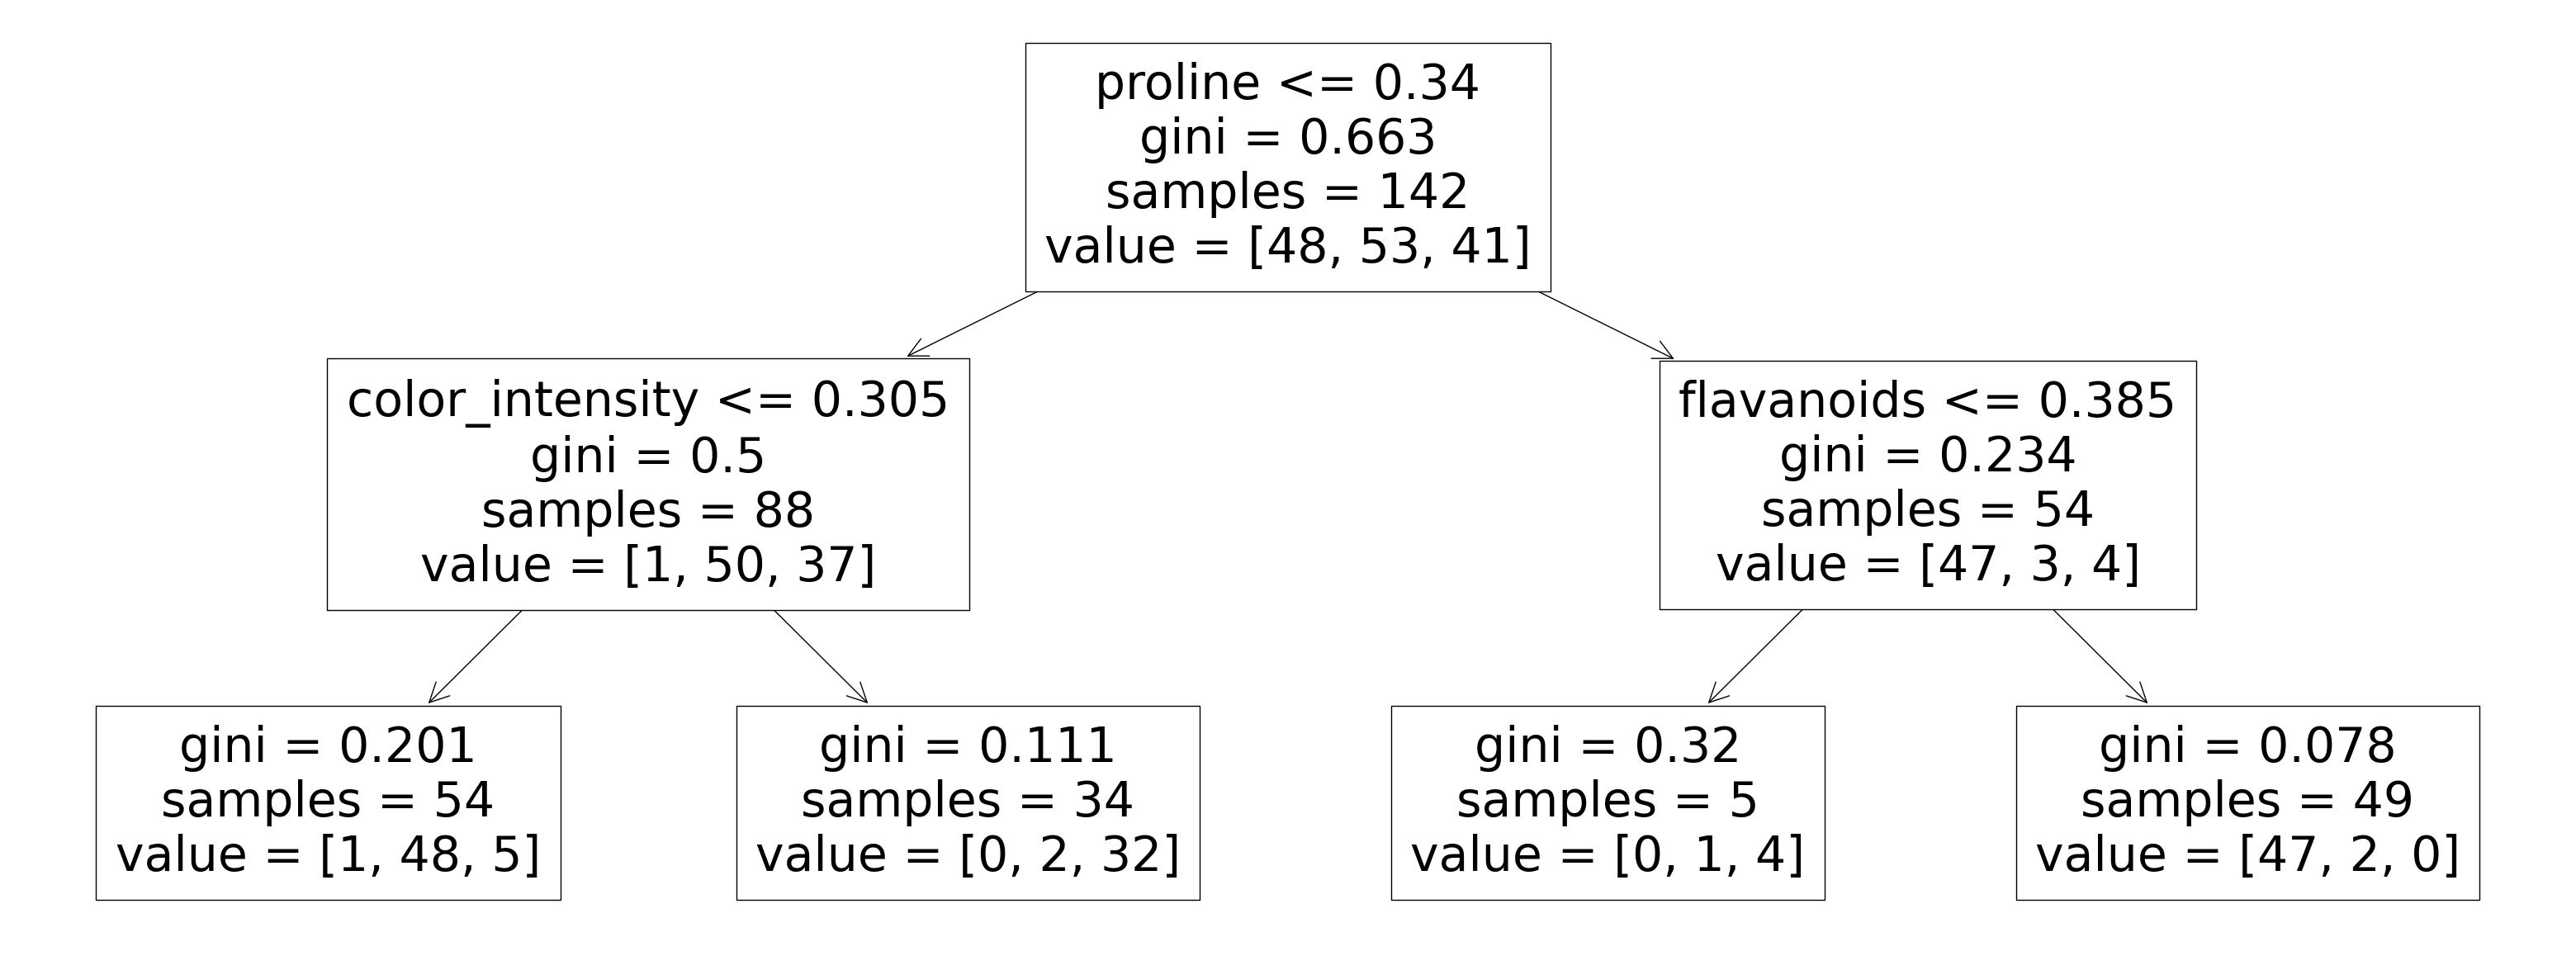

In [9]:
# Goal: Train a decision tree, plot it, and calculate its accuracy.
from sklearn.metrics import accuracy_score
gini_tree = DecisionTreeClassifier(criterion = "gini", max_depth=2, random_state=random_seed).fit(X=X_train, y=Y_train)
plt.figure(figsize=(40,15))
wine_features = wine_data.iloc[:,0:-1]
_ = plot_tree(gini_tree, feature_names=wine_features.columns)
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

### Test GINI Tree - max_depth: 3

Train Accuracy: 0.9788732394366197
Test Accuracy: 0.9444444444444444


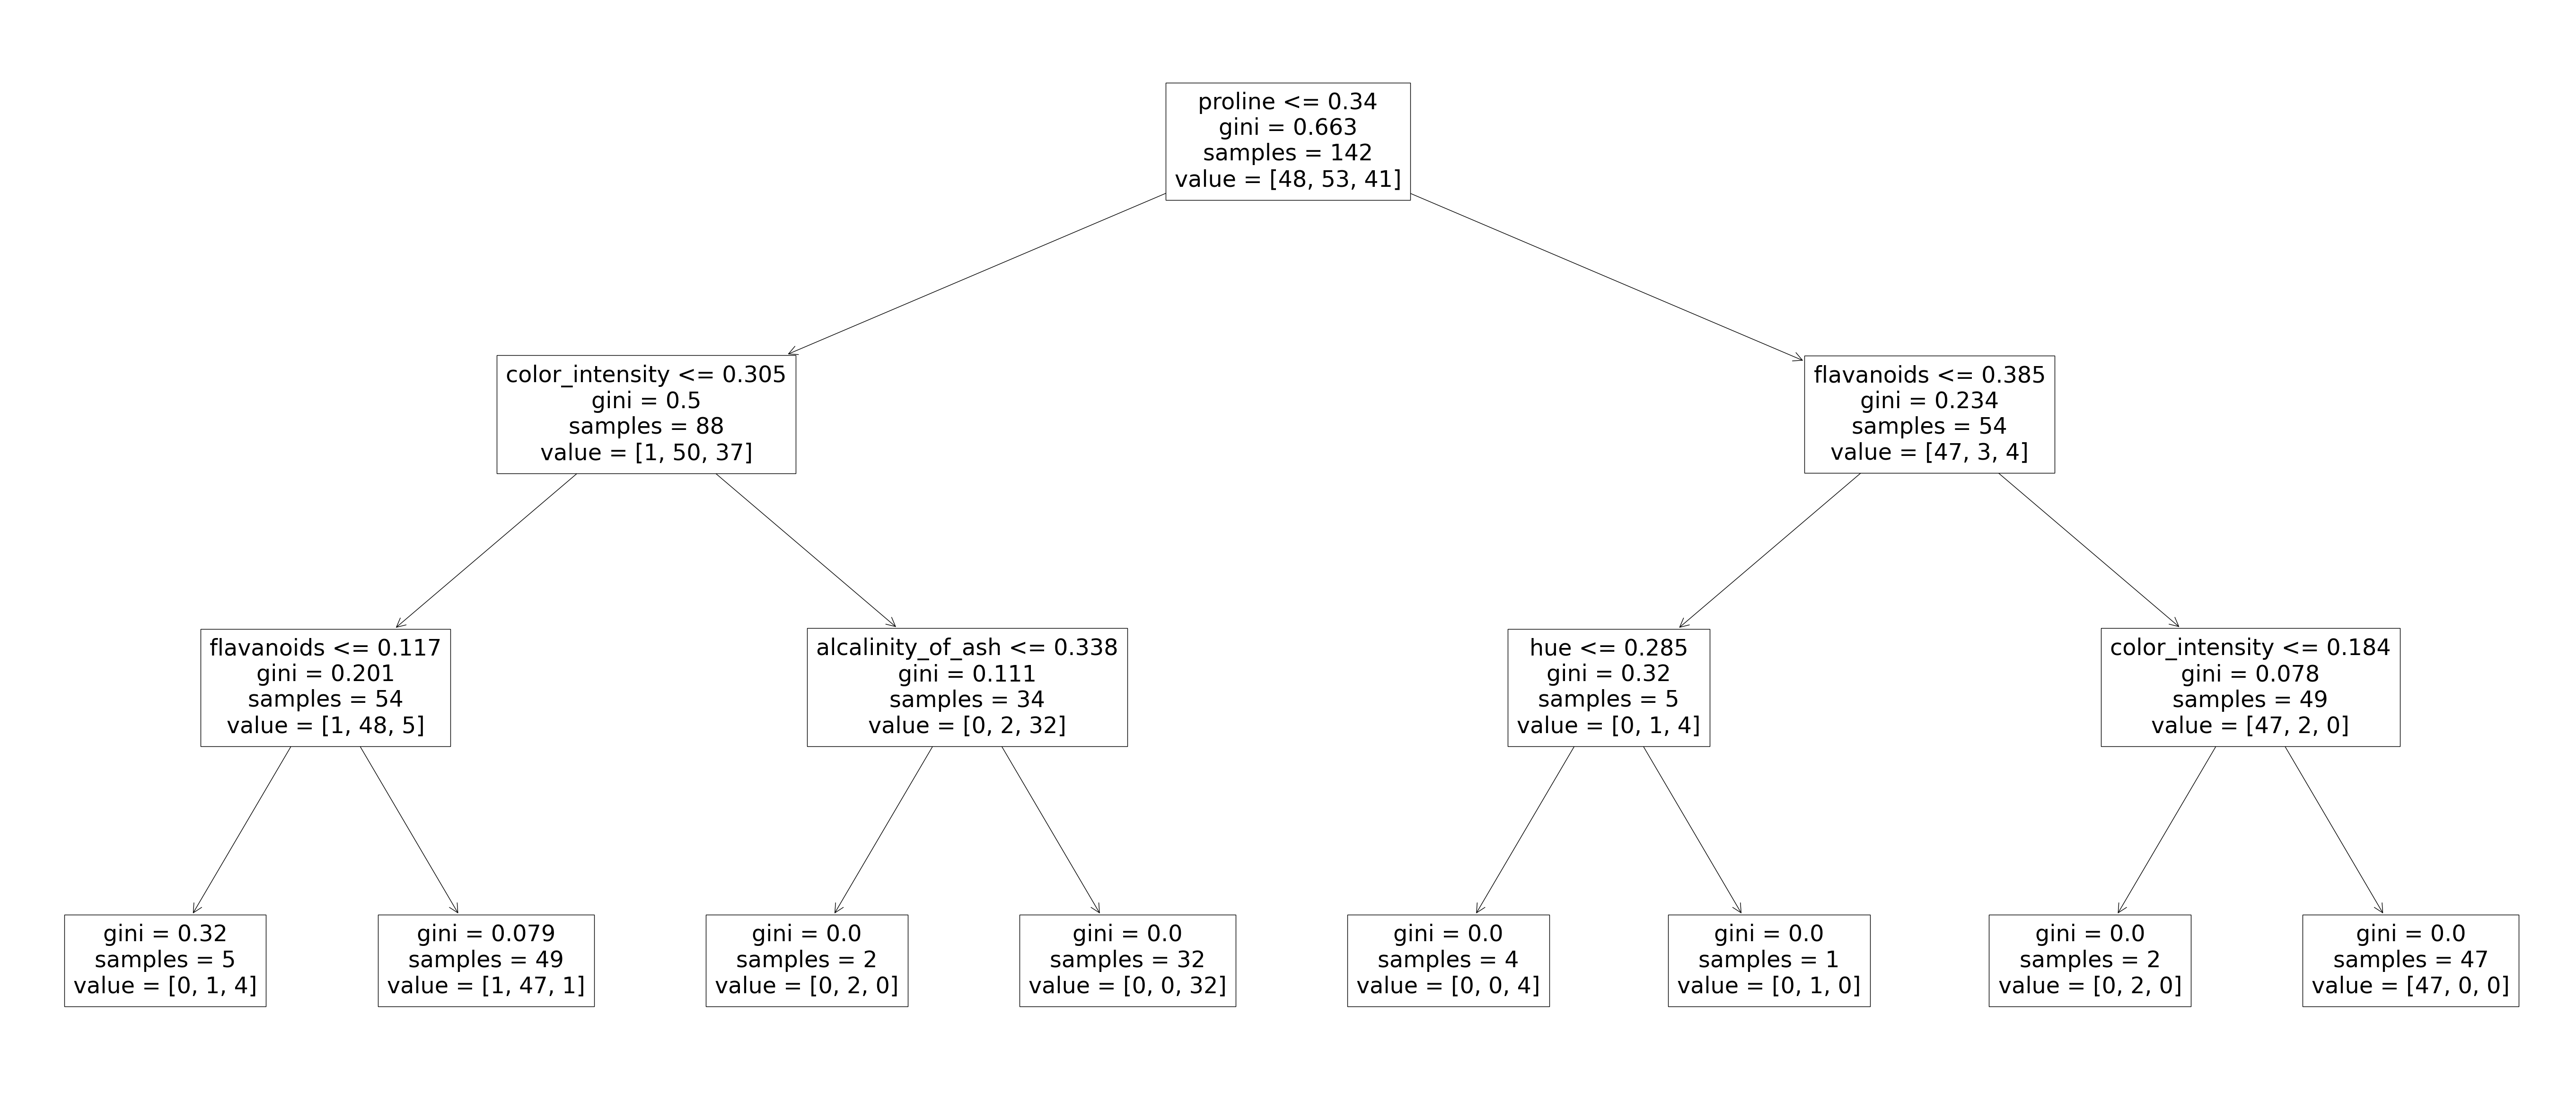

In [10]:
gini_tree = DecisionTreeClassifier(criterion = "gini", max_depth=3, random_state=random_seed).fit(X=X_train, y=Y_train)
plt.figure(figsize=(70,30))
wine_features = wine_data.iloc[:,0:-1]
_ = plot_tree(gini_tree, feature_names=wine_features.columns)
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

### Test GINI Tree - max_depth: None

Train Accuracy: 1.0
Test Accuracy: 0.8888888888888888


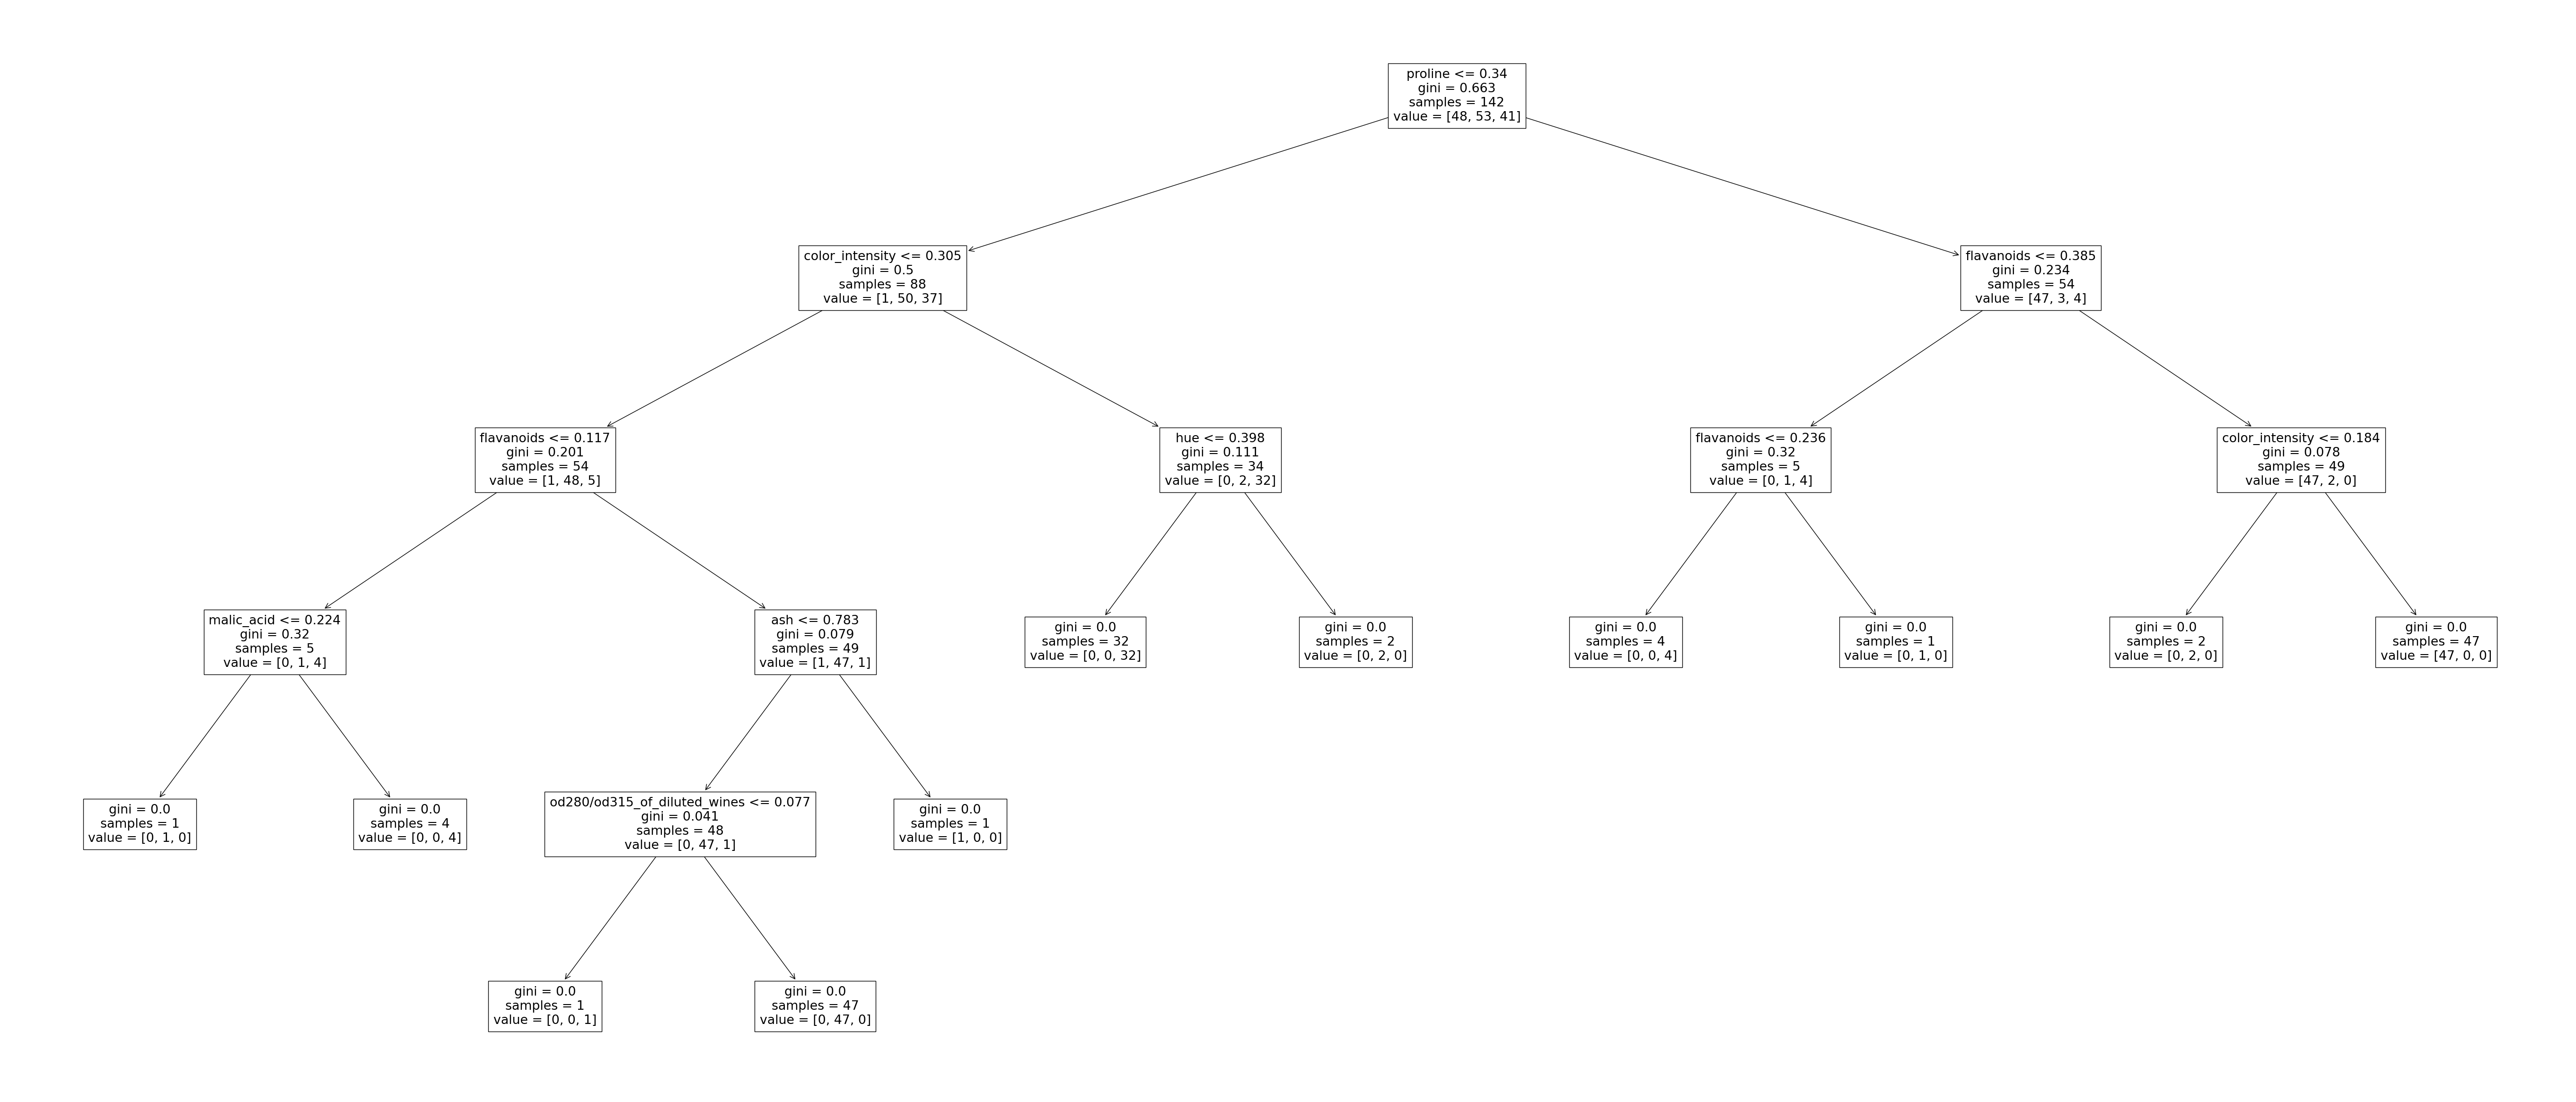

In [11]:
gini_tree = DecisionTreeClassifier(criterion = "gini", max_depth=None, random_state=random_seed).fit(X=X_train, y=Y_train)
plt.figure(figsize=(70,30))
wine_features = wine_data.iloc[:,0:-1]
_ = plot_tree(gini_tree, feature_names=wine_features.columns)
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

In the above example, we set the `max_depth=2`. Play around with different values for `max_depth`. How does the training/test accuracy change? What is the biggest the tree can be (without pre-pruning)? What do you think is the right size of the tree? Why? **Discuss and explain your reasoning here.**

**Answer here:**

**How does the training/test accuracy change?**

If we lower the max_depth to one or zero, the test accuracy will decrease along with the training accuracy. If we raise the max_depth beyond three, the training accuracy will raise and eventually become 100% while the test accuracy will decrease below 90%. Raising the max_depth from 2 to 3 raises the training accuracy to 97.88% and test accuracy to 94.44%. 

**What is the biggest the tree can be (without pre-pruning)?**

It seems that the biggest the tree can be is a max_depth of 5 with 21 nodes. This is taken from setting the max_depth of the tree to None.

**What do you think is the right size of the tree? Why?**

The right size of the tree should be a tree with a max_depth of 3. Decreasing the max_depth lowers the training and test accuracy, but raising the max_depth beyond three only improves training accuracy and actually lowers test accuracy below what the 94.44% accuracy resulting from the max_depth of 3 gini tree. Raising the max_depth from 2 to 3 helped raise the test accuracy so a max_depth of 3 would be a better tree than 2 for the given data set. 

### Min Impurity Decrease

Read the documentation for [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and take note of the various params that can be used for pre-pruning.

This parameter set the minimium amount that the impurity (e.g. GINI Index) must go down when we split on a node, for that split to be allowed. If the minimum is 0 (default), this isn't a restriction. If it is high (e.g. 0.3), only very effective splits will be allowed, and we'll have a smaller tree. Note that this is still *pre-pruning* because we stop the tree from growing.

Accuracy with Impurity Decrease 0.05
Train Accuracy: 0.9225352112676056
Test Accuracy: 0.9166666666666666


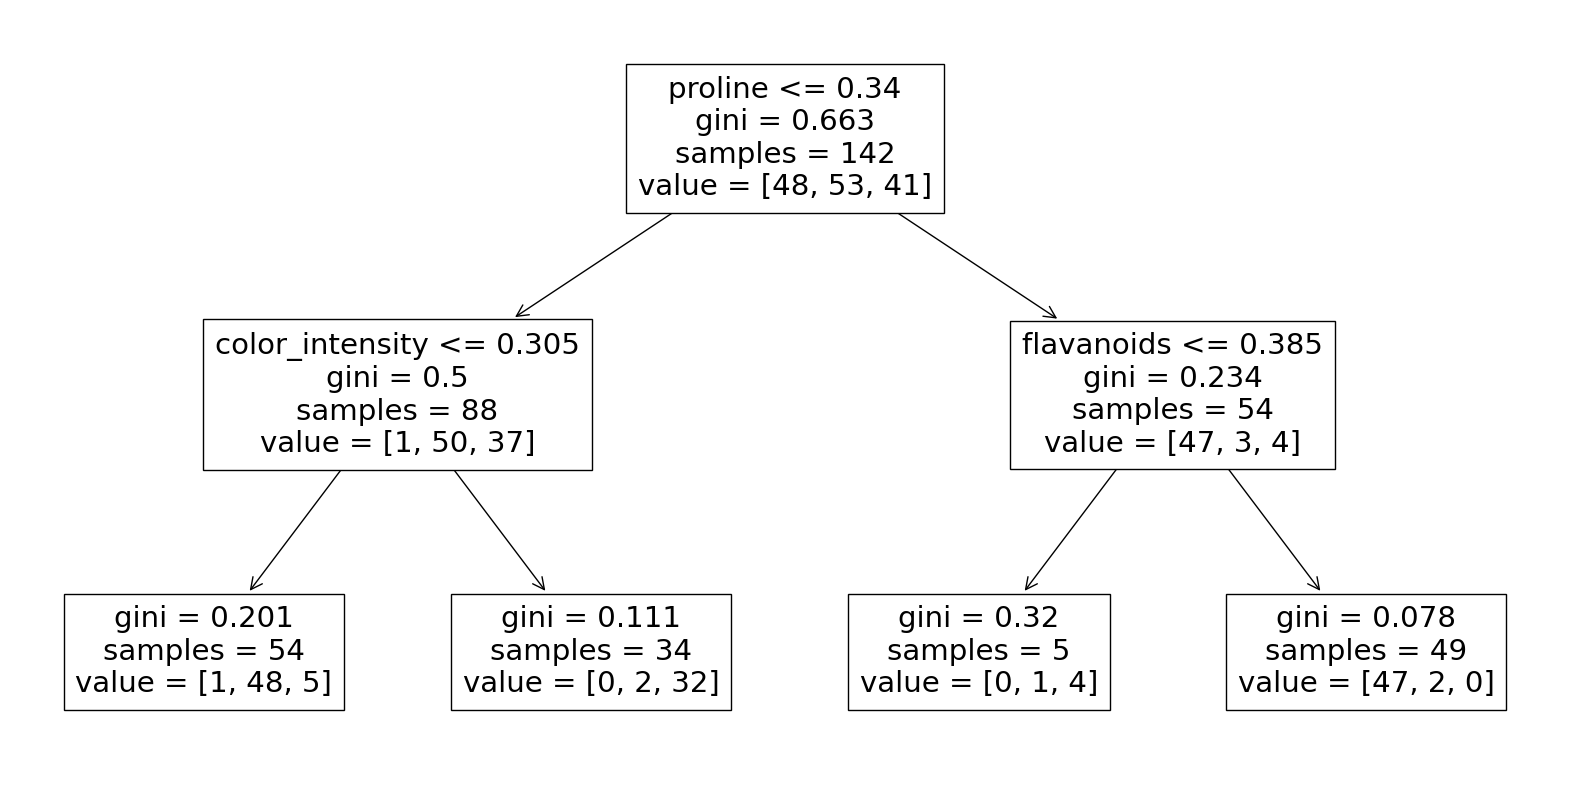

In [12]:
impurity_decrease = 0.05
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed, min_impurity_decrease=impurity_decrease).fit(X=X_train, y=Y_train)
plt.figure(figsize=(20,10))
_ = plot_tree(gini_tree, feature_names=wine_features.columns)
print(f"Accuracy with Impurity Decrease {impurity_decrease}")
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

Accuracy with Impurity Decrease 0.1
Train Accuracy: 0.8943661971830986
Test Accuracy: 0.8611111111111112


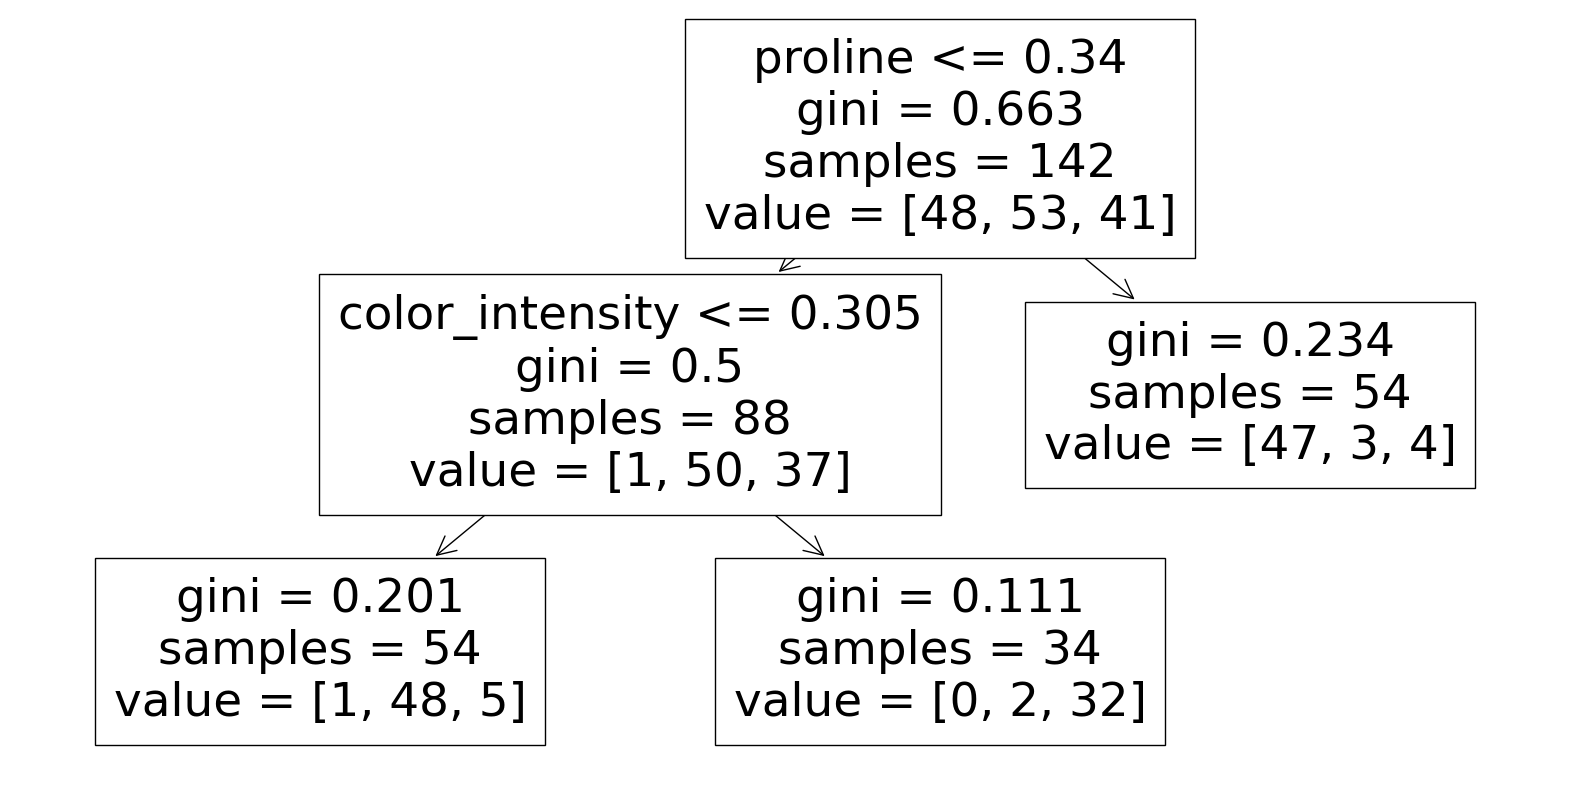

In [13]:
# However, if you go too far you end up decrease both the training and test accuracy
impurity_decrease = 0.1
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed, min_impurity_decrease=impurity_decrease).fit(X=X_train, y=Y_train)
plt.figure(figsize=(20,10))
_ = plot_tree(gini_tree, feature_names=wine_features.columns)
print(f"Accuracy with Impurity Decrease {impurity_decrease}")
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

There are other methods for pre-pruning, but we won't explore them today.
Read the documentation for [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and take note of the various params that can be used for pre-pruning. These are

* `max_depth`
* `min_samples_split`
* `min_samples_leaf`
* `max_features`
* `max_leaf_nodes`
* `min_impurity_decrease` (already covered)

## 2.2 Post Pruning [Cost Complexity Pruning]

Sklearn implements an advanced form of post-pruning: [cost complexity pruning (CCP)](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html). The idea is essentially to see if estimated error improves after pruning certain nodes after the tree is built. The amount of the tree pruned is controlled by the paramater `ccp_alpha`. 

Below, complete the `dt_performace` function to train and evaluate a decision tree with the given `ccp_alpha` value. Then try some different values of `ccp_alpha` in the range (0,0.3) to see their effect on the accuracy.

Accuracy with ccp_alpha=0.1
Train Accuracy: 0.8943661971830986
Test Accuracy: 0.8611111111111112


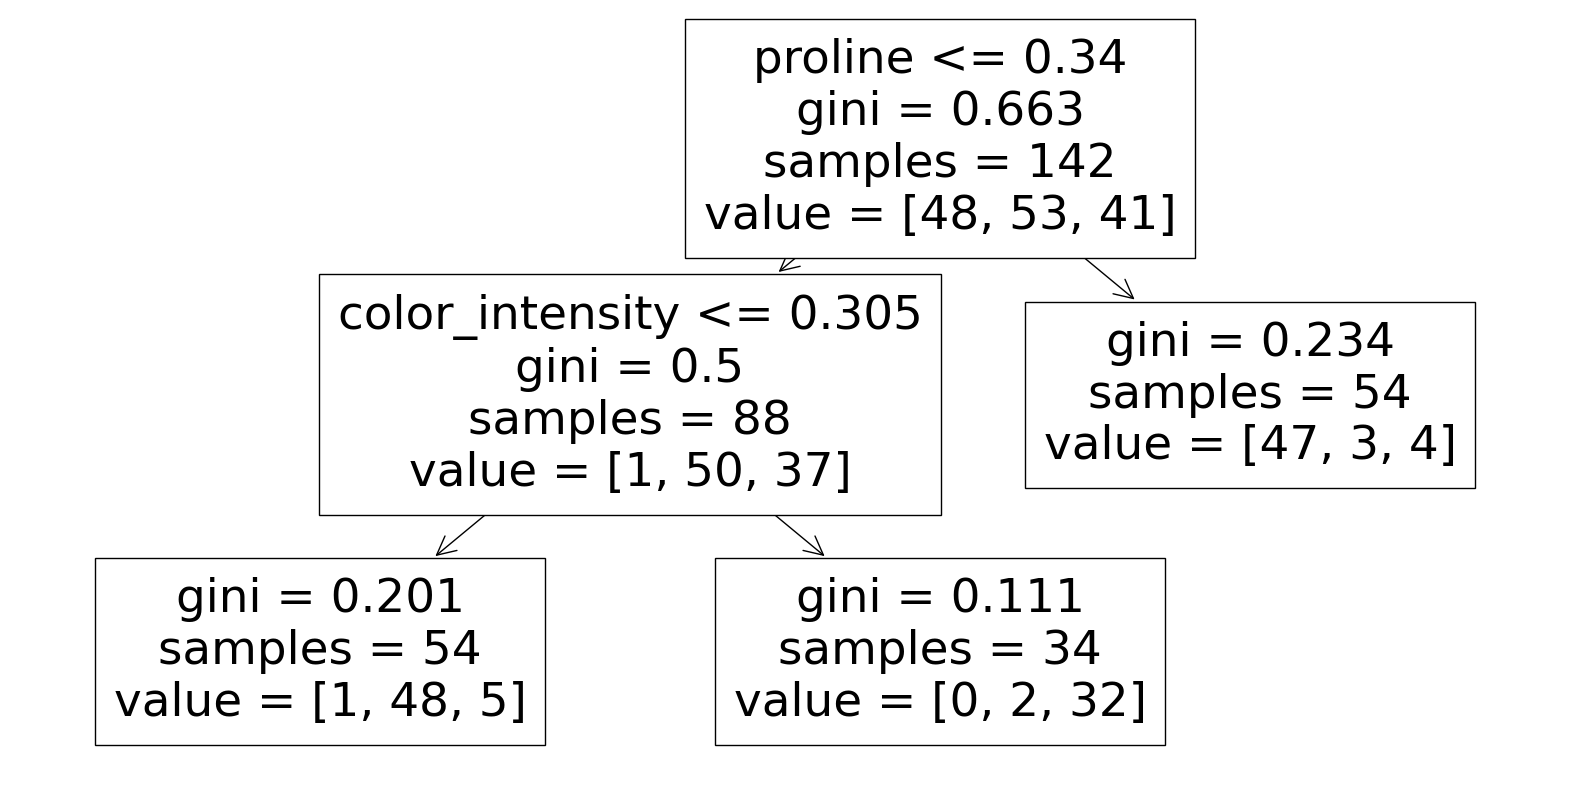

In [14]:
def dt_performance(ccp_alpha, X_train, Y_train, X_test, Y_test, random_seed):
    gini_tree = train_acc_value = test_acc_value = None
    # Build a decision tree using ccp_alpha
    ### BEGIN SOLUTION
    
    gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed, ccp_alpha=ccp_alpha).fit(X=X_train, y=Y_train)
    train_acc_value = accuracy_score(Y_train, gini_tree.predict(X_train))
    test_acc_value = accuracy_score(Y_test, gini_tree.predict(X_test))

    ### END SOLUTION
    
    return gini_tree, train_acc_value, test_acc_value
    


ccp_alpha = 0.1
gini_tree, trainin_acc_value, test_acc_value = dt_performance(ccp_alpha, X_train, Y_train, X_test, Y_test, random_seed)

# Now test with multiple ccp_alpha values and see how training and testing accuracy change.
print(f"Accuracy with ccp_alpha={ccp_alpha}")
print(f'Train Accuracy: {accuracy_score(Y_train, gini_tree.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(Y_test, gini_tree.predict(X_test))}')

plt.figure(figsize=(20,10))
_ = plot_tree(gini_tree, feature_names=wine_features.columns)

In [15]:
np.testing.assert_almost_equal(gini_tree.predict(wine_data.iloc[:3,0:-1]), [0., 0., 0.])

In [16]:
ht_X_train, ht_X_test, ht_Y_train, ht_Y_test = train_test_split(wine_data.iloc[:,0:-1], wine_data.iloc[:,-1], test_size=0.2, random_state=1234)
ht_gini_tree, ht_train_acc_value, ht_test_acc_value = dt_performance(0.1, ht_X_train, ht_Y_train, ht_X_test, ht_Y_test, 1234)
np.testing.assert_almost_equal(ht_gini_tree.predict(wine_data.iloc[20:30,0:-1]), [0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

# 3 Cross Validation and Hyperparmeter Tuning

In this problem you will be using cross-validation to evaluate a model and to tune a hyperparameter.

## 3.1 Example: Basic Cross Validation

Here is an example of using K-fold cross validation for hyperpareter tuning.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [18]:
# Read the wine dataset and translate to pandas dataframe
wine_sk = datasets.load_wine()
# Note that the "target" attribute is species, represented as an integer
wine_data = pd.DataFrame(data= np.c_[wine_sk['data'], wine_sk['target']],columns= wine_sk['feature_names'] + ['target'])

We next need to define out training dataset and test dataset. Remember we can only use our **training** dataset (`X_train`) to select out hyperparameters, so we'll define that first.

In [19]:
from sklearn.model_selection import train_test_split
# The fraction of data that will be test data
# We've put it artificially high so the folds below are easier to read
test_data_fraction = 0.90

wine_features = wine_data.iloc[:,0:-1]
wine_labels = wine_data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(wine_features, wine_labels, test_size=test_data_fraction,  random_state=random_seed)

In [20]:
# Initialize a k-fold splitter
kf = KFold(n_splits=3)

# Kf.split() allows you to iterate though the different folds
# "train_index" are the indices of the training data in that fold
# "test_index" are the indices of the testing data in that fold
for train_index, test_index in kf.split(X_train):
    print("Train: ", train_index)
    print("Test: ", test_index)
    print("----")

Train:  [ 6  7  8  9 10 11 12 13 14 15 16]
Test:  [0 1 2 3 4 5]
----
Train:  [ 0  1  2  3  4  5 12 13 14 15 16]
Test:  [ 6  7  8  9 10 11]
----
Train:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test:  [12 13 14 15 16]
----


The above code defined 3 folds of data within the training data. We can use those train/validation combinations to  evaluate a given hyperparameter. 

## 3.2 Hyperparameter Tuning with CV

In practice, you generally won't include your test dataset in hyperparameter tuning as you don't want the selection of hyperparameters being associated with the test data. Therefore, in this exercise we'll be trying out different HPs by constructing validation sets from our training data.

The dataset we'll be using for this exercise is the breast cancer dataset, which is used to tell if a certain individal might have breast cancer or not.

In [21]:
import sklearn.metrics

# Load the data
# Read the breast cancer dataset and translate to pandas dataframe
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

bc_sk = datasets.load_breast_cancer()

# Make sure data is in the same range
bc_sk.data = MinMaxScaler().fit_transform(bc_sk.data)

# Note that the "target" attribute is species, represented as an integer
bc_data = pd.DataFrame(data= np.c_[bc_sk['data'], bc_sk['target']],columns= list(bc_sk['feature_names'])+['target'])
bc_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0


In [22]:
# Create the initial train/test folds
test_data_fraction = 0.2
bc_features = bc_data.iloc[:,0:-1]
bc_labels = bc_data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(bc_features, bc_labels, test_size=test_data_fraction,  random_state=random_seed)

In [23]:
def k_fold_accuracy(k, model, X_data, Y_data):
    """
    You will need to implement a k-fold cross validation with accuracy as the performance metric.
    
    Your inputs and outputs are specified as below:
    
    Input:
        k: An integer indicates the number of fold to do cross validation.
        model: A DecisionTreeClassifier instance.
        X_data: A numpy array of shape (n_data_rows, n_attributes) where n_data_rows refers to 
              the number of rows in your dataset and n_attributes refers to the number of attributes. 
              This typically is from the training dataset.
        Y_data: A numpy array of shape (n_data_rows, ) containing the class labels for each row in your 
              dataset. This typically is from the training dataset.
    Output:
        scores: A list of length k, with scores[i] containing the validation accuracy score for the i-th fold.
    """
    # Init k-fold splitter
    kf = KFold(n_splits=k)
    scores = []
    
    ### BEGIN SOLUTION

    for train_index, test_index in kf.split(X_data):
        
        X_train = X_data.iloc[train_index]
        X_test = X_data.iloc[test_index]
        Y_train = Y_data.iloc[train_index]
        Y_test = Y_data.iloc[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        scores.append(accuracy)
    
    ### END SOLUTION

    return scores

In [24]:
# Testing K-fold
k = 3
model = DecisionTreeClassifier(criterion = "gini", random_state=random_seed)
per_fold_acc = k_fold_accuracy(k, model, X_train, Y_train)
print(per_fold_acc)
np.mean(per_fold_acc)

[0.9539473684210527, 0.9605263157894737, 0.9205298013245033]


0.9450011618450098

In [25]:
k = 3
test_model = DecisionTreeClassifier(criterion = "gini", random_state=234)
per_fold_acc = k_fold_accuracy(k, test_model, X_train, Y_train)
np.testing.assert_almost_equal(per_fold_acc, [0.9473684210526315, 0.9539473684210527, 0.9403973509933775])

There also exists a built in sklearn function for this, however it is import to know how to perform your own k-fold cross validation split if you want to implement a custom evaluation metric.

In [26]:
from sklearn import metrics
# We're using the trianing dataset here, but remember that CV will
# split that data into training and validation sets for each fold
# so we get an "unbiased" estimate of our test performance.
per_fold_acc = cross_val_score(model, X_train, Y_train, cv=KFold(n_splits=k), scoring='accuracy')
print(per_fold_acc)
np.mean(per_fold_acc)

[0.95394737 0.96052632 0.9205298 ]


0.9450011618450098

*Why would we ever do this by hand, if there's already a built-in method?* 

Sometimes our model training process is more complex than just fitting the model. For example, we may want to do:
* Feature selection
* Normalization / scaling
* More complex models not in the sklearn library

In these cases, we can still *only use our training data*! You can't use test data to select features - that would be "cheating." So everying that you use your training data for has to occur within the loop we wrote for CV, above, based on the training data for the particular fold we're evaluating.

sklearn also has a feature called [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which we'll be exploring in the future, to make this easier.

## 3.3 Tuning

In this problem you are going to select the best hypterparameter, using *only the training dataset*. No peaking at the test dataset. To estimate how well a given hyperparameter value will do on *unseen* data, we can use Crossvalidation (within the training dataset) to evaluate our model.

Let's use this approach to select the best `ccp_alpha` hyperparameter for a Decision Tree model.

In the following cell, you should write code to:
1. Iterate over all ccp_alpha values. For each ccp_alpha value, do step 2-3.
2. Calculate the k_fold validation accuracy using the above funciton.
3. Calculate the training accuracy and the validation accuracy.
4. Plot both accuracies vs. the ccp_alpha value.

Don't forget to set your decision tree's **random_state=random_seed** for consistent output.

Text(0, 0.5, 'Average Accuracy of 5-fold validation')

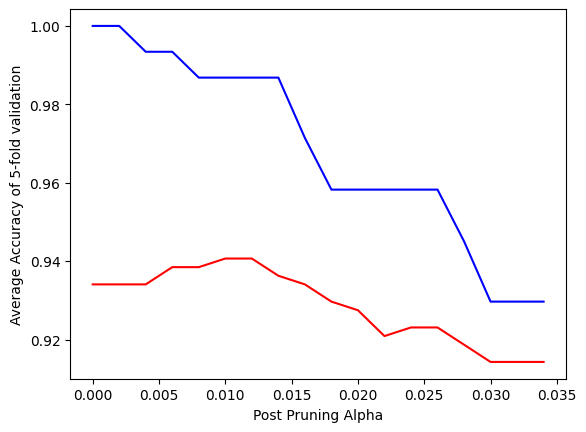

In [27]:
from sklearn.metrics import accuracy_score

# np.arange generates a list that starts at minimum, ends at maximum, and increments by step
alpha_values = np.arange(0, 0.035, 0.002)

# two lists to hold our accuracy
k = 5
valid_accs = []
train_accs = []

# TODO: fill the valid_accs and train_accs lists with the model performance for the corresponding ccp_alpha values
### BEGIN SOLUTION

for ccp_alpha in alpha_values:
    model = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=ccp_alpha)
    fold_acc = k_fold_accuracy(k, model, X_train, Y_train)
    avg_fold_acc = np.mean(fold_acc)
    valid_accs.append(avg_fold_acc)
    
    model.fit(X_train, Y_train)
    train_predictions = model.predict(X_train)
    train_acc = accuracy_score(Y_train, train_predictions)
    train_accs.append(train_acc)

### END SOLUTION    

plt.plot(alpha_values, valid_accs, color='red')
plt.plot(alpha_values, train_accs, color='blue')
plt.xlabel("Post Pruning Alpha")
plt.ylabel(f'Average Accuracy of {k}-fold validation')

In [28]:
np.testing.assert_almost_equal(train_accs, [1.0, 1.0, 0.9934065934065934, 0.9934065934065934, 0.9868131868131869, 0.9868131868131869, 0.9868131868131869, 0.9868131868131869, 0.9714285714285714, 0.9582417582417583, 0.9582417582417583, 0.9582417582417583, 0.9582417582417583, 0.9582417582417583, 0.945054945054945, 0.9296703296703297, 0.9296703296703297, 0.9296703296703297])
np.testing.assert_almost_equal(valid_accs, [0.9340659340659341, 0.9340659340659341, 0.9340659340659341, 0.9384615384615385, 0.9384615384615385, 0.9406593406593406, 0.9406593406593406, 0.9362637362637363, 0.9340659340659341, 0.9296703296703297, 0.9274725274725275, 0.9208791208791208, 0.923076923076923, 0.923076923076923, 0.9186813186813186, 0.9142857142857143, 0.9142857142857143, 0.9142857142857143])

**Now answer the following questions:**
1. How does training accuracy change as the alpha value changes? Why?
2. How does the validation accuracy change as the alpha value chanegs? Why?
3. Knowing this, what value would you choose for alpha for the final model? Why? Plot the final decision tree with your alpha selection.

**Discuss here**
1. As the alpha value increases, the training accuracy decreases. This is due to the fact that as the alpha value increases, more of the tree is pruned which results in simpler models that may not be as accurate compared to a more complex model which tries to fit everything the training dataset has to offer.
2. The validation accuracy increases slightly before decreasing as alpha value increases. The slight increase at the beginning when the alpha value first starts to increase may be because the decision tree is being pruned to help remove some overfitting to the training dataset. After a certain point, the validation accuracy starts decreasing which might be because too many branches of the tree is being pruned resulting in an oversimplified model that may be underfit. 
3. I would choose the alpha value that has the highest validation accuracy because that would mean the tree is pruned so that it is not overfitted to the training dataset but also not underfitted because it is pruned to much to the point that it is too simple to make accurate decisions. From the chart, it seems the best alpha value would be somewhere between 0.01 and 0.015.

The following code selects the alpha value for the best model. Then you job is to train a new model (using all of the training data), using your best hyperparameter value. Then evaluate it on the test dataset using accuracy score. 

In [29]:
# Take the alpha for the model with the best accuracy on the *validation* set!
best_alpha = alpha_values[np.argmax(valid_accs)]
best_alpha

0.01

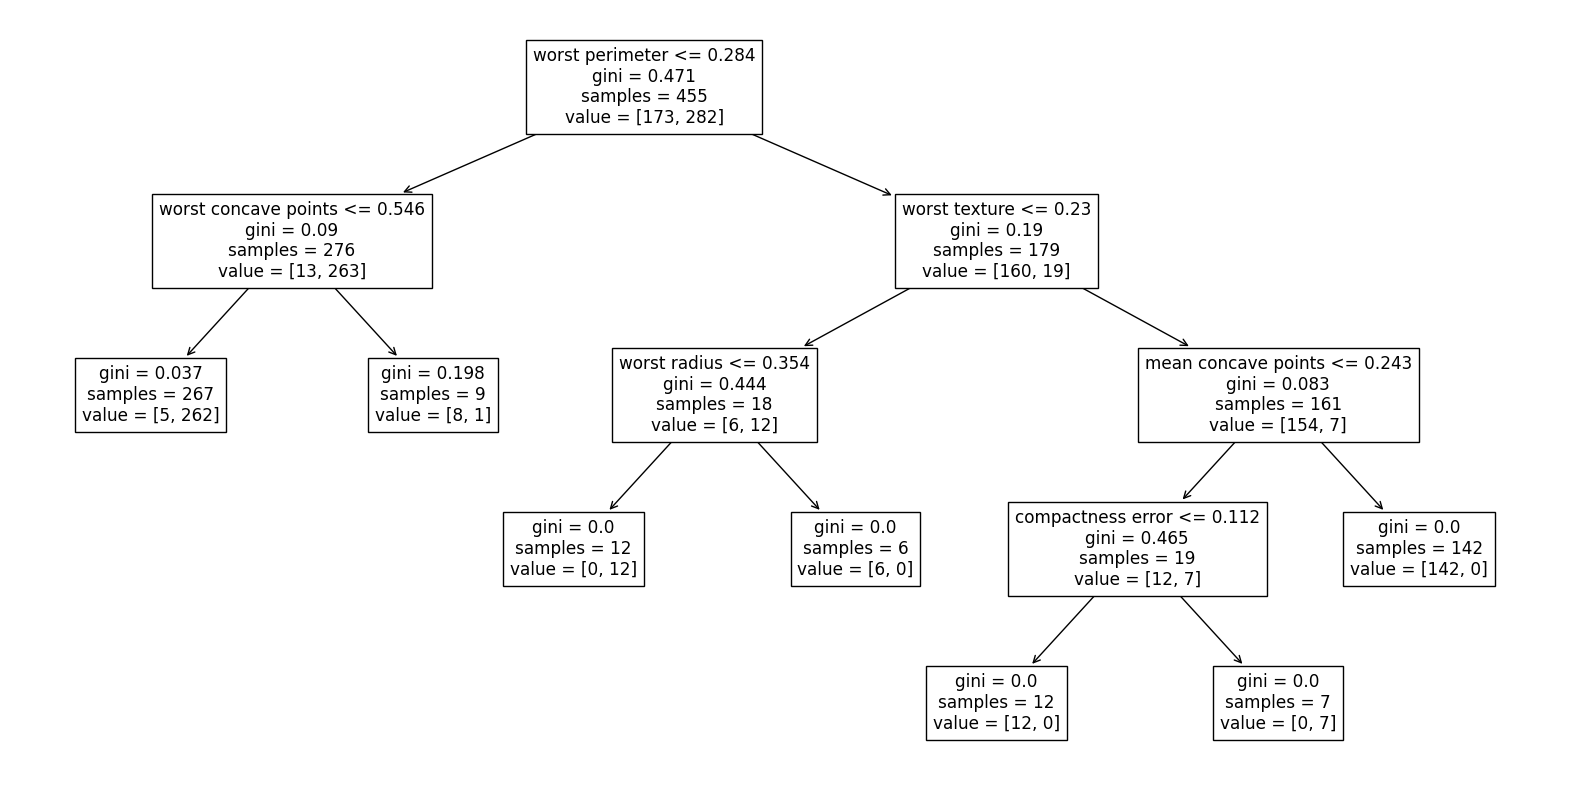

In [30]:
# Train your decision tree classifier here with ccp_alpha equals to the best alpha find above.
# Your decision tree should use gini index as split critirion.
# Don't forget to set random_state=random_seed.
# You may want to print the tree using plot_tree

gini_tree = None

#TODO: construct the gini_tree
### BEGIN SOLUTION

gini_tree = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_alpha, random_state=random_seed)

gini_tree.fit(X_train, Y_train)

### END SOLUTION

plt.figure(figsize=(20,10))
_ = plot_tree(gini_tree, feature_names=bc_features.columns)

In [31]:
# Now evaluate your model on the test dataset - what are the evaluation metrics?

y_test_accuracy = None
### BEGIN SOLUTION

y_predict = gini_tree.predict(X_test)

y_test_accuracy = accuracy_score(Y_test, y_predict)

### END SOLUTION

print(y_test_accuracy)

0.9385964912280702


In [32]:
assert y_test_accuracy == 0.9385964912280702